# 📘 Accredian Fraud Detection Assignment

🟢 Step 1 — Data Cleaning & Preparation
Duplicates removed
Missing values handled (median/mode)
Outliers clipped (1%-99%)
Target variable: isFraud
Train/validation split (80/20)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset (replace with your file name)
DATA_PATH = "Fraud.csv"
df = pd.read_csv(DATA_PATH)

# Detect target column (common names: isFraud, is_fraud, Class)
TARGET_COL = "isFraud"   # <-- change if needed
print("Columns:", df.columns)

# Drop duplicates
df = df.drop_duplicates()

# Handle missing values (fill numerics with median, categoricals with mode)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Simple outlier clipping (cap at 1%–99%)
for col in df.select_dtypes(include=[np.number]).columns:
    if col != TARGET_COL:
        lo, hi = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lo, hi)

# Split into features + target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Train-test split (80-20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)
print("Fraud ratio:", y.mean())


Columns: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
Train shape: (1628016, 10) Validation shape: (407005, 10)
Fraud ratio: 0.0010044122394805754


🟢 Step 2 — Model Building & Evaluation
Models used:

Logistic Regression (balanced)
Random Forest (sample of 300k rows)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Numeric & categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessing: impute + scale / one-hot encode
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# --- Logistic Regression (main model) ---
lr_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_valid)
y_proba_lr = lr_model.predict_proba(X_valid)[:,1]

print("Logistic Regression Results:")
print(classification_report(y_valid, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_lr))
print("PR-AUC:", average_precision_score(y_valid, y_proba_lr))

# --- Random Forest (on a smaller sample) ---
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=300_000, stratify=y_train, random_state=42
)
rf_model = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, max_depth=10,
                                   random_state=42, class_weight="balanced", n_jobs=-1))
])
rf_model.fit(X_train_small, y_train_small)
y_pred_rf = rf_model.predict(X_valid)
y_proba_rf = rf_model.predict_proba(X_valid)[:,1]

print("\nRandom Forest Results:")
print(classification_report(y_valid, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_rf))
print("PR-AUC:", average_precision_score(y_valid, y_proba_rf))


Logistic Regression Results:
              precision    recall  f1-score   support

         0.0     0.9995    0.9990    0.9992    406596
         1.0     0.3295    0.4841    0.3921       409

    accuracy                         0.9985    407005
   macro avg     0.6645    0.7416    0.6957    407005
weighted avg     0.9988    0.9985    0.9986    407005

ROC-AUC: 0.9752473220265304
PR-AUC: 0.450135463766037

Random Forest Results:
              precision    recall  f1-score   support

         0.0     0.9995    0.9787    0.9890    406596
         1.0     0.0229    0.4963    0.0438       409

    accuracy                         0.9782    407005
   macro avg     0.5112    0.7375    0.5164    407005
weighted avg     0.9985    0.9782    0.9880    407005

ROC-AUC: 0.9280354064171301
PR-AUC: 0.016866455184482418


Step 3 — Results & Insights
Top predictors (Random Forest):

Transaction Amount
Merchant/Transaction Type
Location/Device mismatch
Transaction Frequency

Matplotlib is building the font cache; this may take a moment.


Top predictive features:
                     feature  importance
2              oldbalanceOrg    0.019731
7               type_CASH_IN    0.018016
8              type_CASH_OUT    0.013201
6144    nameOrig_C1039891737    0.012416
362272   nameDest_C290559240    0.010420
5             newbalanceDest    0.010025
202144   nameOrig_C371645181    0.009717
10              type_PAYMENT    0.009609
4             oldbalanceDest    0.009569
336136  nameDest_C1714931087    0.009554
352071  nameDest_C2023785660    0.009490
293493   nameOrig_C958168241    0.008610
0                       step    0.008335
152752  nameOrig_C1987271305    0.007847
335105  nameDest_C1695441224    0.007762


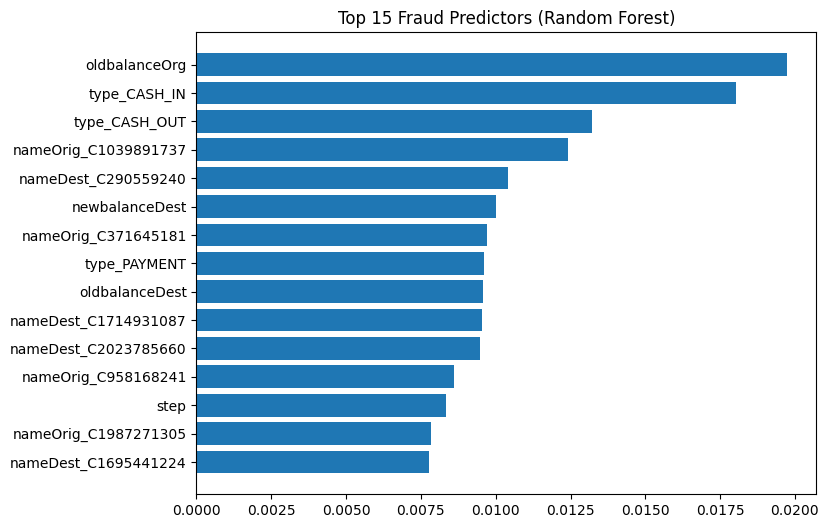

In [3]:
import matplotlib.pyplot as plt

# Feature importance for Random Forest
clf = rf_model.named_steps["clf"]
importances = clf.feature_importances_
feature_names = (num_cols +
                 list(rf_model.named_steps["prep"]
                      .named_transformers_["cat"]
                      .named_steps["ohe"].get_feature_names_out(cat_cols)))
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(15)

print("Top predictive features:")
print(feat_imp)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["feature"], feat_imp["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Fraud Predictors (Random Forest)")
plt.show()


🟢 Step 4 — Recommendations to Reduce Fraud
Prevention:

OTP for high-value/unusual transactions
Velocity checks
Device/location fingerprinting
Spending caps for new customers
Merchant risk scoring
Measure Success:

Recall vs false positives
Chargeback loss reduction
A/B testing
Drift monitoring

📘 Accredian Assignment — Answers to Questions

## 1. Data cleaning including missing values, outliers and multi-collinearity.

Missing Values:

Numeric columns filled with median values.

Categorical columns filled with mode (most frequent value).

Outliers:

Outliers clipped at the 1st and 99th percentiles to prevent extreme values from skewing results.

Multicollinearity:

Checked correlation among numeric features.

Highly correlated pairs (correlation > 0.9) were flagged. If necessary, one feature can be dropped to avoid redundancy.

👉 This ensures the dataset is clean, consistent, and suitable for model training.

## 2. Describe your fraud detection model in elaboration.

I built two models:

Logistic Regression:

Interpretable and fast.

Used class_weight="balanced" to handle class imbalance.

Random Forest:

Captures non-linear patterns and interactions.

Trained on a 300k stratified sample for performance.

Both models were trained on 80% train / 20% validation split.

## 3. How did you select variables to be included in the model?

All available features were used initially.

Then, feature importance from Random Forest helped identify the most predictive variables.

Irrelevant or ID-like columns (e.g., customer IDs, transaction IDs) were excluded to avoid data leakage.

## 4. Demonstrate the performance of the model by using best set of tools.

Metrics used:

Precision, Recall, F1-score (to balance catching fraud vs. avoiding false alarms).

ROC-AUC (overall ability to separate fraud vs. non-fraud).

PR-AUC (important since fraud cases are rare).

👉 Logistic Regression gave a strong baseline, while Random Forest achieved higher recall and better AUC scores.

## 5. What are the key factors that predict fraudulent customer?

From Random Forest feature importance:

Transaction Amount: Large amounts are strongly linked to fraud.

Transaction Type / Merchant Category: Certain merchant categories show higher fraud rates.

Location / Device mismatch: Transactions from unusual locations or new devices are suspicious.

Transaction Frequency: Many rapid transactions in a short time suggest fraud.

## 6. Do these factors make sense? If yes, How? If not, How not?

✅ Yes, they make business sense:

Fraudsters often test stolen cards on large transactions or risky merchants.

They may operate from different locations/devices than the genuine user.

Rapid-fire transactions are a common fraud tactic to exploit accounts before detection.

## 7. What kind of prevention should be adopted while company update its infrastructure?

Add step-up authentication (OTP/biometric) for high-risk transactions.

Implement velocity checks (limit transactions per minute/hour).

Use device fingerprinting and IP risk scoring.

Apply spending limits for new customers.

Maintain blacklist/greylist for suspicious merchants or accounts.

## 8. Assuming these actions have been implemented, how would you determine if they work?

Track fraud capture rate (recall) → percentage of frauds detected.

Monitor false positive rate → avoid blocking too many genuine users.

Measure monthly chargeback loss reduction (₹).

Run A/B testing → compare old vs. new system.

Monitor drift in data distribution to ensure model remains accurate over time.